# Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

+ DESCR: 데이터셋 설명

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


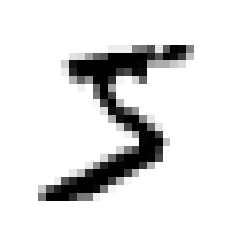

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, -1)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
import numpy as np

y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Transfer problem to binary classification

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [7]:
sgd_clf.predict([some_digit]) # 5로 예측함

array([ True])

## Evaluation

### Cross validation

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5): # 3 folds 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


+ 불균형 데이터 셋에서 정확도는 좋은 평가지표가 될 수 없음

In [9]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # 무조건 5는 아님으로 반환

In [10]:
never_5_clf = Never5Classifier() 
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion matrix

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [13]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

### Precision and recall

In [14]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

+ f1 score

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Tradeoff between precision and recall 

In [17]:
sgd_clf.decision_function([some_digit]) # 0 이상이면 True

array([2164.22030239])

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

+ 정밀도는 못맞춘 케이스의 영향력이 커지므로 임계값이 올라도 낮아지는 경우가 있을 수 있음
+ 재현률은 부드러운 곡선

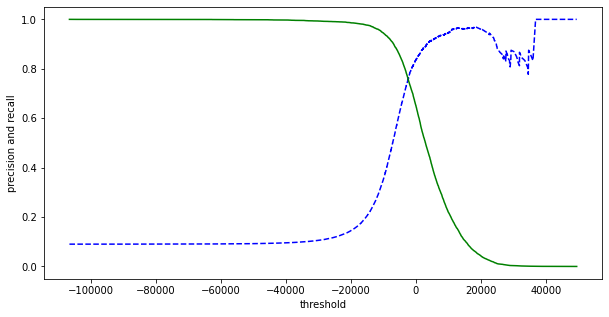

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax):
    ax.plot(thresholds, precisions[:-1], "b--", label="precision")
    ax.plot(thresholds, recalls[:-1], "g-", label="recall")
    ax.set_xlabel("threshold")
    ax.set_ylabel("precision and recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax=ax)
plt.show()

+ precision 90%에서 threshold를 설정

In [21]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)] # 3370.0194 (첫번쩨 값을 반환)
y_train_pred_90 = y_scores >= threshold_90_precision

In [22]:
precision_score(y_train_5, y_train_pred_90) # 의도한 90%

0.9000345901072293

In [23]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706